# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants

import matplotlib.pyplot as plt
import matplotlib.colors

import mpl_interactions.ipyplot as iplt

#plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Define 'global' Constants

In [2]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=1

I = 0 #W/m^2
E = 0 #V/m

GAUSS = 1e4 # T
B_MIN = 0.01 / GAUSS # T
B_MAX = 400 / GAUSS # T
B_STEPS = 100

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T

def btoi(b):
    return (b-B_MIN)/B_STEP_SIZE

def itob(i):
    return B_STEP_SIZE*i+B_MIN

# Build and Diagonalise Hamiltonian for many B

In [3]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, Rb87Cs133, zeeman=True, Edc=True, ac=True)

H = H0[..., None]+\
    Hz[..., None]*B+\
    Hdc[..., None]*E+\
    Hac[..., None]*I
H = H.transpose(2,0,1)

ENERGIES, STATES = eigh(H)

ENERGIES, STATES, LABELS = calculate.sort_by_state(ENERGIES, STATES, N_MAX, Rb87Cs133)

# Helper Functions

In [4]:
def label_to_state_no(N,MF,k):
    for i, label in enumerate(LABELS):
        if label[0] == N and label[1] == MF and label[2] == k:
            return i

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = int(I1*2)
    I2d = int(I2*2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

# General Constants

In [5]:
INITIAL_STATE_LABEL = (0,5,0)
INITIAL_STATE_POSITION = label_to_state_no(*INITIAL_STATE_LABEL)

# Ordered by energy low->high at 181.5G 
ACCESSIBLE_STATE_LABELS = [(1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
ACCESSIBLE_STATE_POSITIONS = [label_to_state_no(N,MF,k) for N,MF,k in ACCESSIBLE_STATE_LABELS]

CONSIDERED_STATE_LABELS = [INITIAL_STATE_LABEL] + ACCESSIBLE_STATE_LABELS
CONSIDERED_STATE_POSITIONS = [INITIAL_STATE_POSITION] + ACCESSIBLE_STATE_POSITIONS

# Plot energies over B for N=1 and N=2, highlighting available transitions from spin stretched group state

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


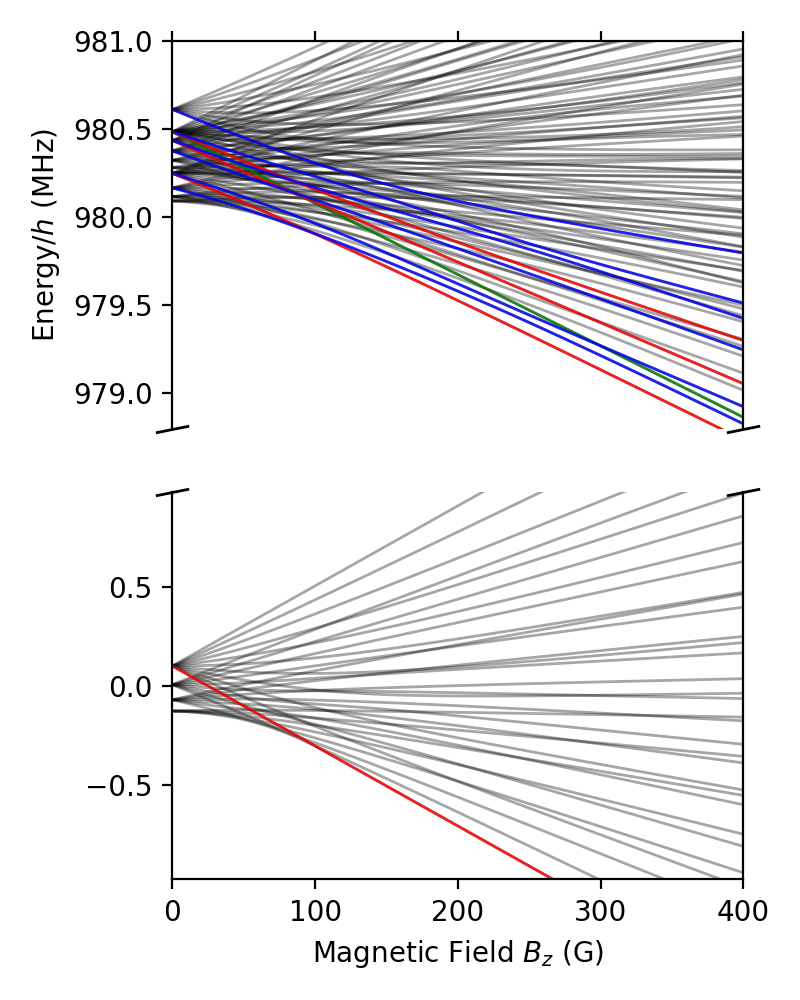

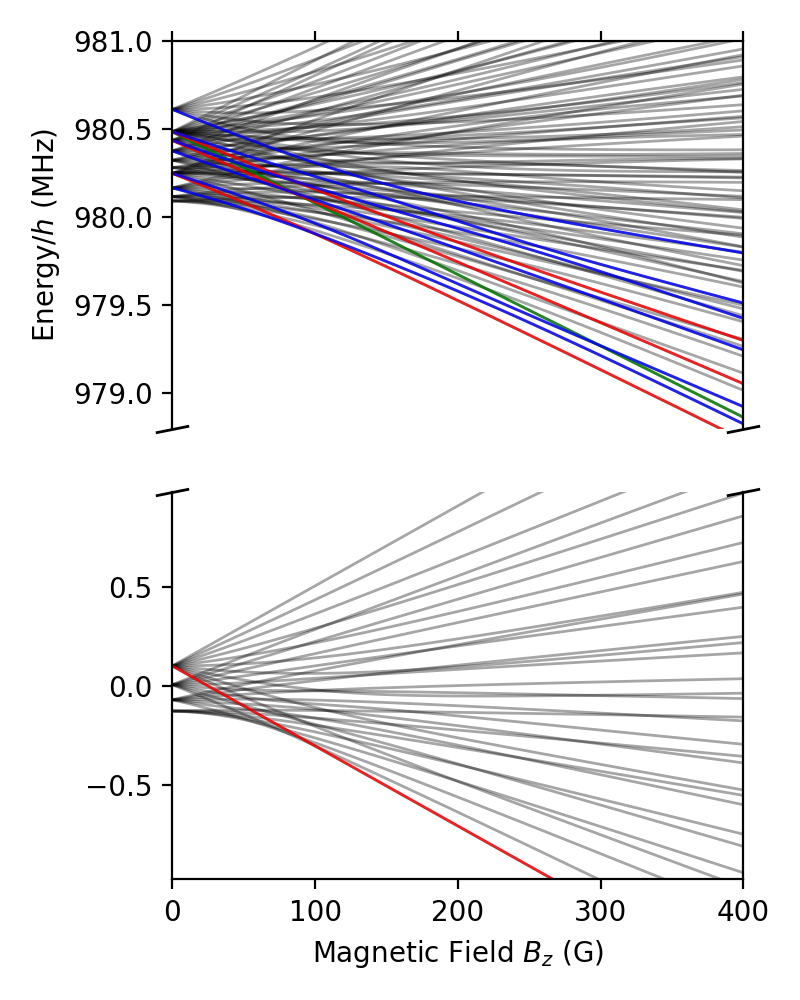

In [6]:
fig, (ax_up, ax_down) = plt.subplots(2,1,sharex=True,figsize=(4,5),dpi=200)

ax_up.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=1, alpha=0.35)
ax_down.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=1, alpha=0.35)

# Highlight available transitions from (0,5,0)
for i, energy in enumerate(ENERGIES.T):
    if (LABELS[i] == [0, 5, 0]).all() or (LABELS[i][0] == 1 and LABELS[i][1] in [4, 5, 6]):
        c=['b','r','g'][int(LABELS[i][1] - 4)]
        a=0.8
        ax_up.plot(B*GAUSS, energy*1e-6/scipy.constants.h, color=c, linewidth=1, alpha=a)
        ax_down.plot(B*GAUSS, energy*1e-6/scipy.constants.h, color=c, linewidth=1, alpha=a)
        
ax_up.set_xlim(0, B_MAX*GAUSS)
ax_up.set_ylim(978.8, 981.0)
ax_down.set_ylim(-0.98, 0.98)
ax_up.set_ylabel("Energy/$h$ (MHz)")
ax_down.set_xlabel("Magnetic Field $B_z$ (G)")

# Split axes formatting
ax_up.spines.bottom.set_visible(False)
ax_down.spines.top.set_visible(False)
ax_up.xaxis.tick_top()
ax_up.tick_params(labeltop=False)
ax_down.xaxis.tick_bottom()
d = .2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_up.plot([0, 1], [0, 0], transform=ax_up.transAxes, **kwargs)
ax_down.plot([0, 1], [1, 1], transform=ax_down.transAxes, **kwargs)

fig.show()

# State mixing composition over B

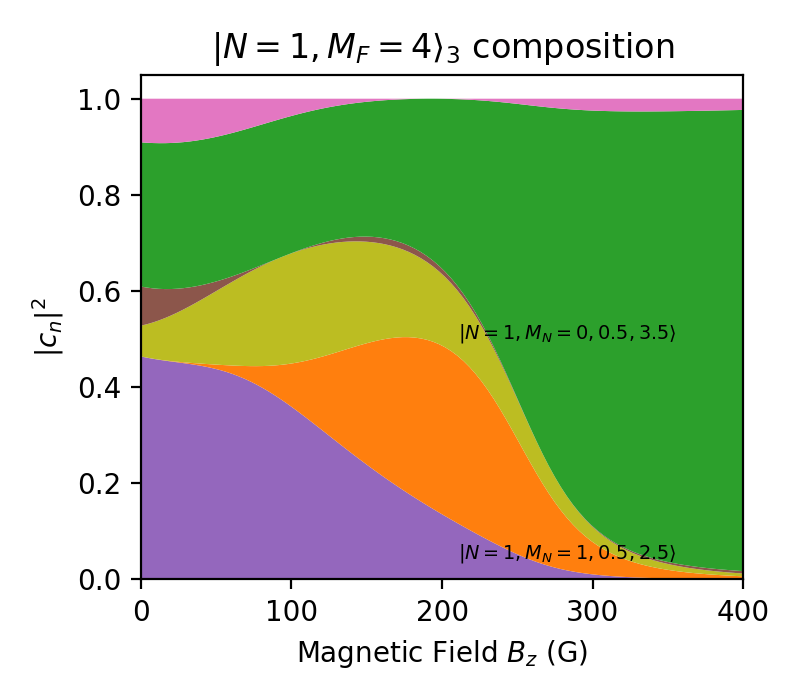

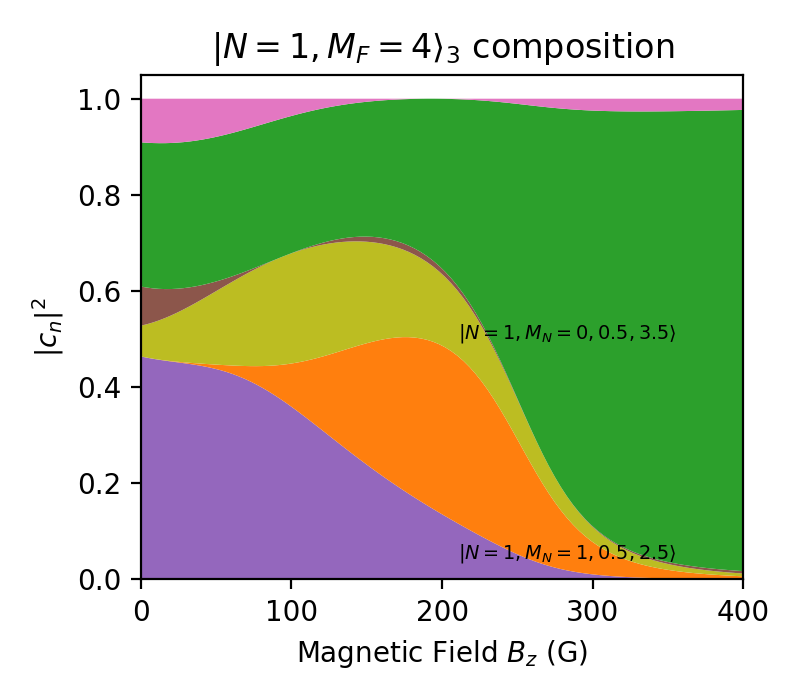

In [7]:
state_label_to_plot = (1, 4, 3)
state_num_to_plot = label_to_state_no(*state_label_to_plot)

fig, ax = plt.subplots()

ax.stackplot(B * 1e4, np.abs(STATES[:, :, state_num_to_plot].T) ** 2)

cumulative=0
for component_state_index, component_state_coef in enumerate(STATES[int(B_STEPS * 0.7), :, state_num_to_plot]):
    if np.abs(component_state_coef) > 0.25:
        component_state_label = state_no_to_uncoupled_label(component_state_index)
        component_state_label_string = r'$|N={},M_N={},{},{}\rangle$'.format(*component_state_label)
        component_state_fraction = np.abs(component_state_coef)**2
        ax.text(B[int(B_STEPS*0.7)]*1e4, cumulative+component_state_fraction/2, component_state_label_string,
                va='center', ha='center', fontsize='x-small')
        cumulative += component_state_fraction

ax.set_ylabel(r"$|c_n|^2$")
ax.set_xlabel(r"Magnetic Field $B_z$ (G)")
ax.set_ylim(0, 1.05)
ax.set_xlim(0, B_MAX*GAUSS)
ax.set_title(r"$|N={},M_F={}\rangle_{}$ composition".format(*state_label_to_plot))

fig.show()

# A4 all states mixing plots

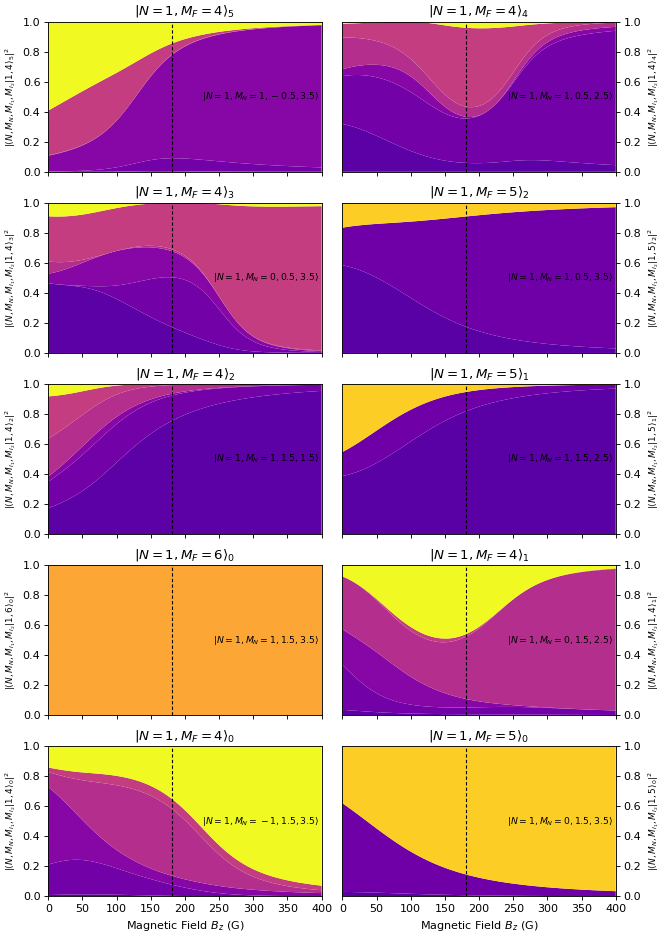

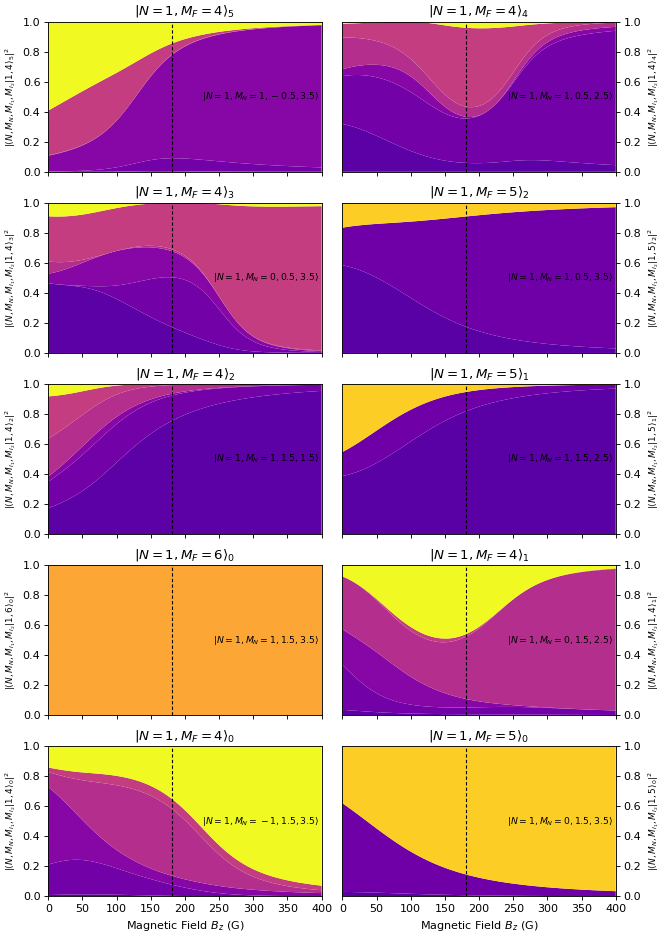

In [8]:
# Set DPI to 600 for print quality
fig, axs = plt.subplots(5,2, figsize=(8.3,11.7), dpi=80, sharex=True, layout="constrained")

state_labels_to_plot = np.flip(np.array(ACCESSIBLE_STATE_LABELS, dtype="i,i,i")).reshape(5,2)

for v, axrow in enumerate(axs):
    for h, ax in enumerate(axrow):
        state_label_to_plot = state_labels_to_plot[v][h]
        state_num_to_plot = label_to_state_no(*state_label_to_plot)

        state_coeffs_to_plot = np.abs(STATES[:, 32:128, state_num_to_plot].T) ** 2
        
        color_map = plt.cm.plasma
        colors = color_map(np.linspace(0.15, 0.9, len(state_coeffs_to_plot)))
        colors_special = color_map(np.linspace(0.8, 1, 3))
        colors[[0,32,64]] = colors_special

        ax.stackplot(B*1e4, state_coeffs_to_plot, colors=colors)
        
        max_comp_state_index = state_coeffs_to_plot[:,-1].argmax()+32
        max_comp_state_label = state_no_to_uncoupled_label(max_comp_state_index)
        max_comp_state_label_string = r'$|N={},M_N={},{},{}\rangle$'.format(*max_comp_state_label)
        ax.text(B_MAX*0.99*GAUSS, 0.5, max_comp_state_label_string,
                va='center', ha='right', fontsize='small')
        
        if h==1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")

        ax.set_ylim(0, 1)
        ax.set_xlim(0, B_MAX*GAUSS)
        ax.set_title(r'$|N={},M_F={}\rangle_{}$'.format(*state_label_to_plot))
        ax.axvline(x=181.5,dashes=(3, 2),color='k',linewidth=1)
        
        ax.set_ylabel(r"$|\langle N,M_N,M_{{I_1}},M_{{I_2}}|{},{}\rangle_{} |^2$".format(*state_label_to_plot),fontsize=8)

[ax.set_xlabel("Magnetic Field $B_z$ (G)") for ax in axs[4,:]]

fig.show()

# Transition Dipole Moments

In [9]:
"""
left = np.conj(states[40,:,initial_state_position])
right = states[40,:,all_state_positions].T
mine1 = np.einsum('i,ij,jk->k',left,dipole_op,right).real
mine2 = (np.conj(states[40,:,initial_state_position]) @ dipole_op @ states[40,:,all_state_positions].T).real
theirs = calculate.transition_dipole_moment(N_MAX,I1,I2,M,states[40],initial_state_position,locs=all_state_positions)
mine3big = (STATES.conj().transpose(0, 2, 1) @ dipole_op @ STATES).real
mine3 = mine3big[40,INITIAL_STATE_POSITION,CONSIDERED_STATE_LABELS]
mine3reduced=mine3big[40][:,CONSIDERED_STATE_LABELS][CONSIDERED_STATE_LABELS]
"""

"\nleft = np.conj(states[40,:,initial_state_position])\nright = states[40,:,all_state_positions].T\nmine1 = np.einsum('i,ij,jk->k',left,dipole_op,right).real\nmine2 = (np.conj(states[40,:,initial_state_position]) @ dipole_op @ states[40,:,all_state_positions].T).real\ntheirs = calculate.transition_dipole_moment(N_MAX,I1,I2,M,states[40],initial_state_position,locs=all_state_positions)\nmine3big = (STATES.conj().transpose(0, 2, 1) @ dipole_op @ STATES).real\nmine3 = mine3big[40,INITIAL_STATE_POSITION,CONSIDERED_STATE_LABELS]\nmine3reduced=mine3big[40][:,CONSIDERED_STATE_LABELS][CONSIDERED_STATE_LABELS]\n"

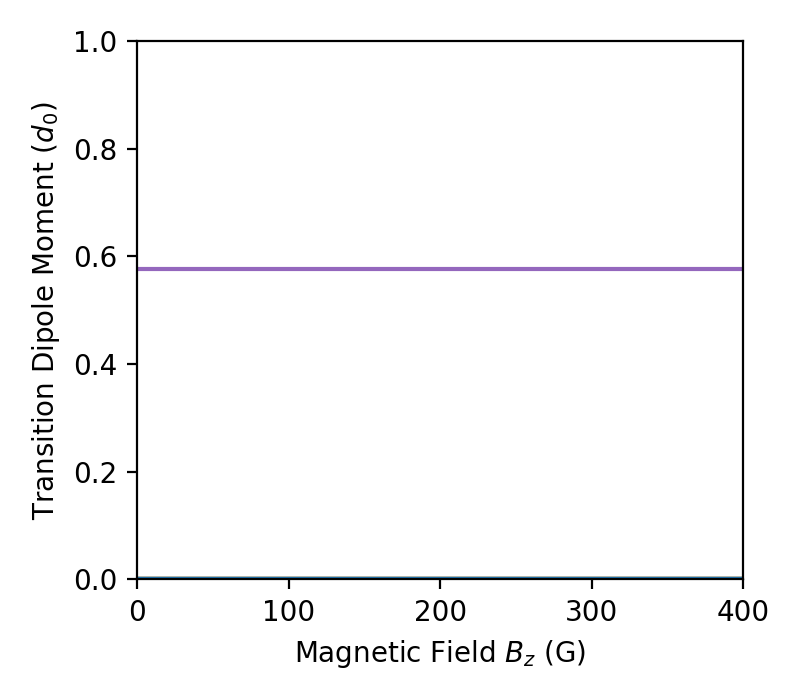

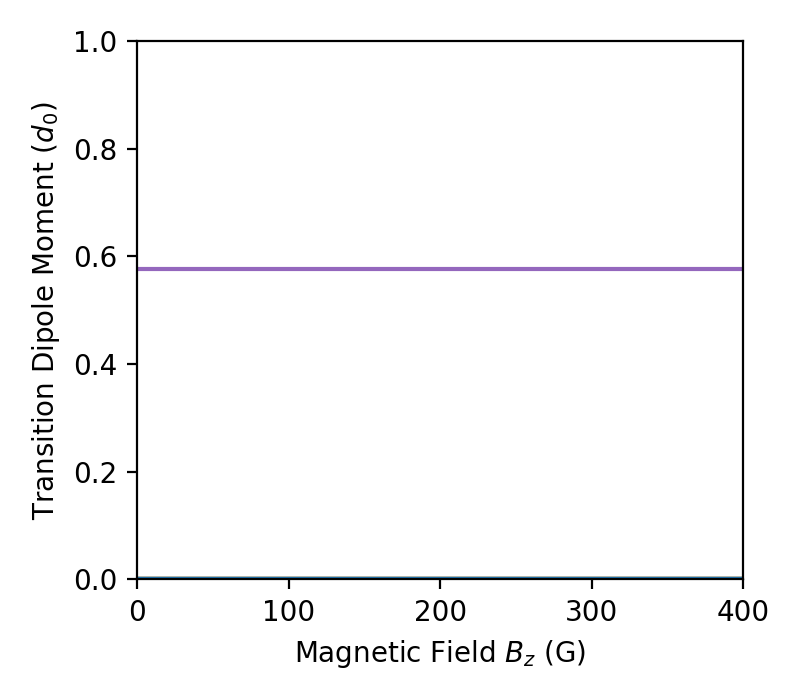

In [10]:
polarisation=-1
dipole_op = calculate.dipole(N_MAX,I1,I2,1,polarisation)
tdm_matrices = (STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op @ STATES[:, :, CONSIDERED_STATE_POSITIONS])).real

fig, ax = plt.subplots()
ax.plot(B * 1e4, np.abs(tdm_matrices[:, INITIAL_STATE_POSITION, :]))
ax.set_xlabel("Magnetic Field $B_z$ (G)")
ax.set_ylabel(r"Transition Dipole Moment $(d_0)$")
ax.set_xlim(0, B_MAX*GAUSS)
ax.set_ylim(0, 1)
fig.show()

# Rabi oscillations
$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$$
$$
H_{ij} = \frac{\hbar}{2} \Omega_{ij} \odot T_{ij}
$$
$$
\Omega_{ij} = \frac{E_0}{\hbar} \bra{i} \mathbf{\hat{d}} \cdot \mathbf{\hat{\epsilon}} \ket{j}
$$
$$
T_{ij} = e^{i(w_{ij}-w)t} + e^{i(w_{ij}+w)t}
$$

In [11]:
calculate.dipole(1,0,0,1,-1).real

array([[0.000e+00, -5.774e-01, 0.000e+00, 0.000e+00],
       [-5.774e-01, 0.000e+00, 0.000e+00, 0.000e+00],
       [-0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [-0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

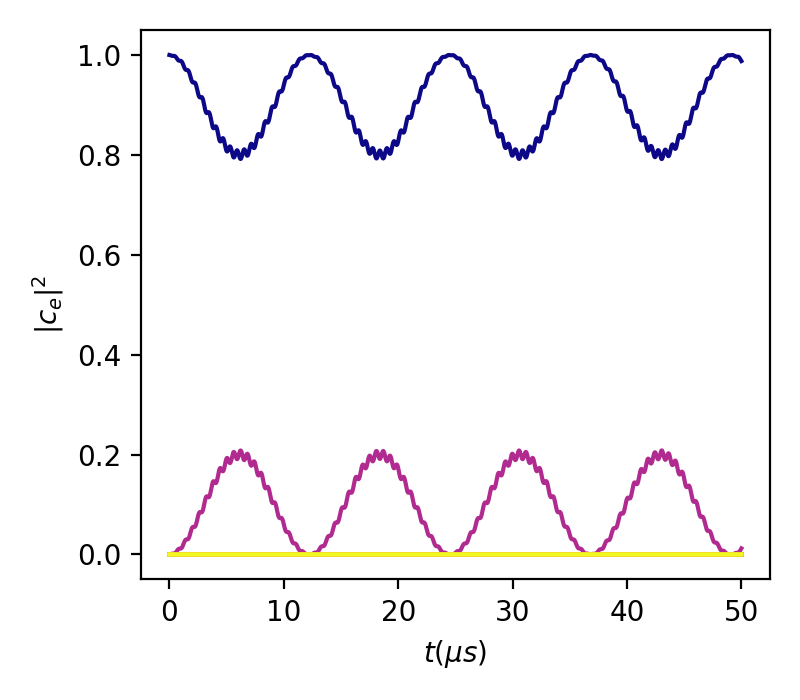

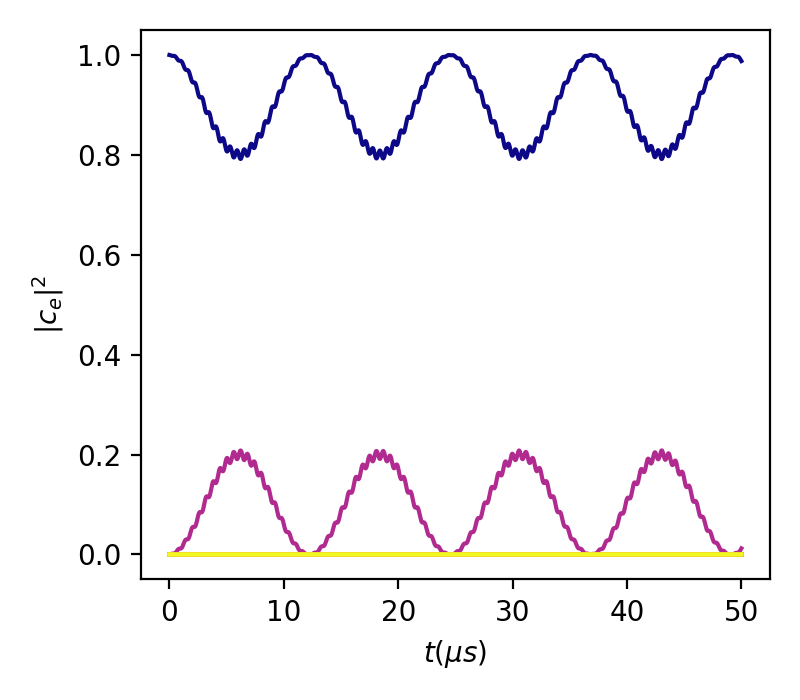

In [12]:
# Experimental Setup
POLARISATION = -1  # -1,0,1
DETUNING = 0 # rad/s
E_0 = 10  # V/m
AT_B_NUM = 40
T_STEPS = 2000
initial_state_considered_index = 0
intended_state_considered_index = 3

N_STATES = len(CONSIDERED_STATE_POSITIONS)

# Relevent energies as frequencies
angular = ENERGIES[AT_B_NUM, CONSIDERED_STATE_POSITIONS].real / H_BAR
driving = angular[intended_state_considered_index] - angular[initial_state_considered_index] + DETUNING

# Construct Rabi coupling matrix
dipole_op = calculate.dipole(N_MAX,I1,I2,D_0,POLARISATION)
coupling = STATES[AT_B_NUM, :, CONSIDERED_STATE_POSITIONS].conj() @ dipole_op @ STATES[AT_B_NUM, :, CONSIDERED_STATE_POSITIONS].T
rabi = (E_0/H_BAR) * coupling

# Construct Time-dependent part
transition_rabi = np.abs(rabi[initial_state_considered_index, intended_state_considered_index])
PULSE_TIME = 2*np.pi/transition_rabi if transition_rabi != 0 else 50e-6
times, DT = np.linspace(0, PULSE_TIME, num=T_STEPS, retstep=True)

wij = angular[:,np.newaxis]-angular[np.newaxis,:]
neg_frequency_part = wij-driving
pos_frequency_part = wij+driving

Ts = np.exp((1j)*neg_frequency_part[np.newaxis,:,:]*times[:,np.newaxis,np.newaxis]) + \
     np.exp((1j)*pos_frequency_part[np.newaxis,:,:]*times[:,np.newaxis,np.newaxis]) #[ti,i,j]

# Construct overall Hamiltonians
Hs = H_BAR/2 * rabi[np.newaxis,:,:] * Ts[:,:,:]  #[ti,i,j]

# Initialise states for each B
state_vector = np.zeros((N_STATES)) # initial state
state_vector[initial_state_considered_index] = 1

# Churn Differential equation
DUs = scipy.linalg.expm(-(1j/H_BAR) * Hs * DT) # Infitesimal unitary transformations

finals = []

for t_num in range(T_STEPS):
    state_vector = DUs[t_num,:,:] @ state_vector
    finals.append(np.abs(state_vector)**2)

fig, ax = plt.subplots()
#ax.set_xlim(0,T_MAX)
#ax.set_ylim(0,1)
ax.set_xlabel("$t (\mu s)$")
ax.set_ylabel("$|c_e|^2$")

colors = plt.cm.plasma(np.linspace(0,1,N_STATES))
for i,final in enumerate(np.array(finals).T):
    ax.plot(times*1e6, final, c=colors[i])
fig.show()

# Transfer efficiency

In [66]:
# Experimental Setup
POLARISATION = 0 # -1,0,1
DETUNING = 0
PULSE_TIME = 100e-6 # s
T_STEPS = 5000
initial_state_label = (0,5,0)
intended_state_label = (1,4,1)
POLARISATION=initial_state_label[1]-intended_state_label[1]

initial_state_considered_index = CONSIDERED_STATE_LABELS.index(initial_state_label)
intended_state_considered_index = CONSIDERED_STATE_LABELS.index(intended_state_label)
initial_state_real_index = CONSIDERED_STATE_POSITIONS[initial_state_considered_index]
intended_state_real_index = CONSIDERED_STATE_POSITIONS[intended_state_considered_index]

N_STATES = len(CONSIDERED_STATE_POSITIONS)

# Relevent energies as frequencies
angular = ENERGIES[:, CONSIDERED_STATE_POSITIONS].real / H_BAR # [B_Number, state]
driving = angular[:, intended_state_considered_index].T - angular[:, initial_state_considered_index] + DETUNING # [B_Number]

# Construct Rabi coupling matrix
dipole_op = calculate.dipole(N_MAX,I1,I2,1,POLARISATION)
couplings = STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op @ STATES[:, :, CONSIDERED_STATE_POSITIONS])
E_0 = np.abs((2*np.pi*H_BAR) / (D_0 * couplings[:, initial_state_considered_index, intended_state_considered_index] * PULSE_TIME))
rabis = (E_0[:,None,None]/H_BAR) * D_0 * couplings # [B_Number, state, state]

# Construct Time-dependent part
times, DT = np.linspace(0, PULSE_TIME, num=T_STEPS, retstep=True)# [ti], []

wij = angular[:,:,np.newaxis]-angular[:,np.newaxis,:]    #[bi,i,j]
neg_frequency_part = wij-driving[:,np.newaxis,np.newaxis]   #[bi,i,j]
pos_frequency_part = wij+driving[:,np.newaxis,np.newaxis]   #[bi,i,j]

Ts = np.exp((1j)*neg_frequency_part[:,np.newaxis,:,:]*times[np.newaxis,:,np.newaxis,np.newaxis]) + \
     np.exp((1j)*pos_frequency_part[:,np.newaxis,:,:]*times[np.newaxis,:,np.newaxis,np.newaxis]) #[bi, ti,i,j]

# Construct overall Hamiltonians
Hs = H_BAR/2 * rabis[:,np.newaxis,:,:] * Ts[:,:,:,:]  #[bi, ti,i,j]

# Infitesimal unitary transformations
DUs = scipy.linalg.expm(-(1j/H_BAR)* Hs * DT) 

# Initialise states for each B
state_vectors = np.zeros((B_STEPS,T_STEPS,N_STATES), dtype=np.cdouble) # initial state
state_vectors[:,0, initial_state_considered_index] = 1

path = np.einsum_path('bij,bi->bj',DUs[:,0,:,:],state_vectors[:,0,:], optimize='optimal')[0]
for t_num in range(T_STEPS-1):
    state_vectors[:,t_num+1,:] = np.einsum('bij,bi->bj',DUs[:,t_num,:,:],state_vectors[:,t_num,:], optimize=path)
    
max_vector = (np.abs(state_vectors)**2).max(axis=1) #[bi,i]

TypeError: <lambda>() got multiple values for argument 'bi'

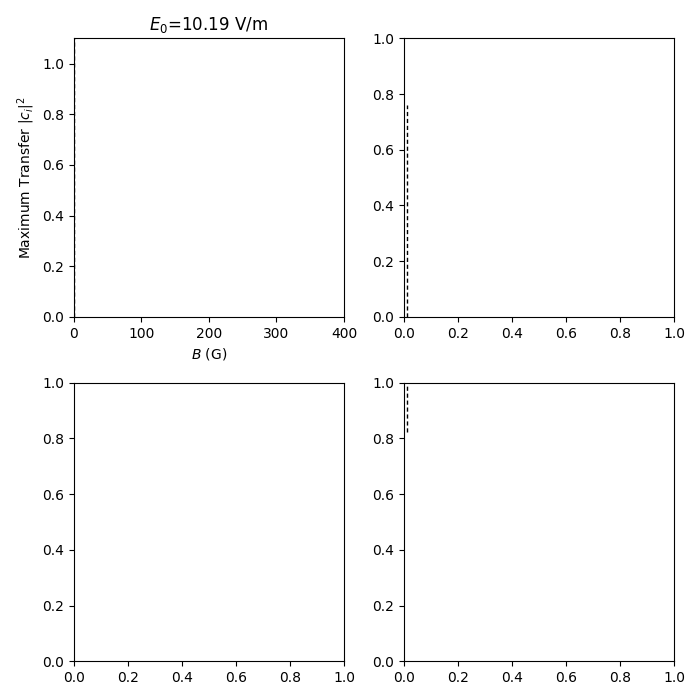

In [71]:
fig, axs = plt.subplots(2,2, figsize=(7,7), dpi=100) 

axupleft = axs[0,0]
axdownleft = axs[1,0]
axupright = axs[0,1]
axdownright = axs[1,1]

STATE_CMAP = plt.cm.gist_rainbow(np.linspace(0,1,N_STATES))

axupleft.set_xlim(0,B_MAX*GAUSS)
axupleft.set_ylim(0,1.1)
axupleft.set_xlabel("$B$ (G)")
axupleft.set_ylabel("Maximum Transfer $|c_i|^2$")

controls = iplt.axvline(x=lambda bi: B[bi]*GAUSS,ax=axupleft,bi=(range(B_STEPS)),dashes=(3, 2),color='k',linewidth=1)

lower_in_all=CONSIDERED_STATE_POSITIONS[initial_state_considered_index]
upper_in_all=CONSIDERED_STATE_POSITIONS[intended_state_considered_index]

LOWER_LIMS = (-1.2, 0.38)
UPPER_LIMS = (978.8, 980.7)

line_ratio = lambda bi, state, limits: (ENERGIES[bi,state].real*1e-6/scipy.constants.h-limits[0])/(limits[1]-limits[0])
iplt.axvline(x=lambda bi: B[bi]*GAUSS, ymax=lambda bi: line_ratio(bi,upper_in_all,UPPER_LIMS), controls=controls["bi"], ax=axupright, dashes=(3, 2),color='k',linewidth=1)
iplt.axvline(x=lambda bi: B[bi]*GAUSS, ymin=lambda bi: line_ratio(bi,lower_in_all,LOWER_LIMS), controls=controls["bi"], ax=axdownright, dashes=(3, 2),color='k',linewidth=1)

iplt.title(lambda bi: f"$E_0$={E_0[bi]:.2f} V/m", controls=controls["bi"],ax=axupleft)

iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,0])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[0])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,1])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[1])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,2])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[2])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,3])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[3])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,4])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[4])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,5])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[5])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,6])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[6])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,7])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[7])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,8])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[8])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,9])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[9])
iplt.plot(times*1e6, lambda t, bi: np.abs(state_vectors[bi,:,10])**2, controls=controls["bi"], ax=axdownleft,c=STATE_CMAP[10])

for state_no in range(1,N_STATES):
    axupleft.plot(B*GAUSS, max_vector[:,state_no],c=STATE_CMAP[state_no])

axdownleft.set_xlim(0,PULSE_TIME*1e6)
axdownleft.set_ylim(0,1.1)
axdownleft.set_xlabel("$t$ $(\mu s)$")
axdownleft.set_ylabel("$|c_i|^2$")

#Plot all energies lightly
axupright.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=0.5, alpha=0.1, zorder=1)
axdownright.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=0.5, alpha=0.1, zorder=1)

#Highlight lower state
axdownright.plot(B*GAUSS, ENERGIES[:,initial_state_real_index]*1e-6/scipy.constants.h, color=STATE_CMAP[initial_state_considered_index], linewidth=1)

#Highlight upper states
for sub_index, real_index in enumerate(ACCESSIBLE_STATE_POSITIONS):
    sub_index += 1
    this_coupling = np.abs(couplings[:, initial_state_considered_index, sub_index])
    this_colour = STATE_CMAP[sub_index]
    metric = this_coupling
    axupright.plot(B * GAUSS, ENERGIES[:, real_index] * 1e-6 / scipy.constants.h, color='k', alpha=0.4,linewidth=0.6, zorder=3)
    axupright.scatter(B * GAUSS, ENERGIES[:, real_index] * 1e-6 / scipy.constants.h, color=this_colour, edgecolors=None,alpha=metric,s=metric*60, zorder=2)
        
axupright.set_xlim(0, B_MAX*GAUSS)
axdownright.set_xlim(0, B_MAX*GAUSS)
axupright.set_ylim(UPPER_LIMS)
axdownright.set_ylim(LOWER_LIMS)
axupright.set_ylabel(" ")
axdownright.yaxis.tick_right()
axdownright.yaxis.set_label_position("right")
axupright.yaxis.tick_right()
axupright.yaxis.set_label_position("right")
fig.text(1.0, 0.5, 'Energy/$h$ (MHz)', ha='right',va='center', rotation='vertical')
axdownright.set_xlabel("Magnetic Field $B_z$ (G)")


axupright.yaxis.set_major_locator(plt.MultipleLocator(0.5))
axupright.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
axdownright.yaxis.set_major_locator(plt.MultipleLocator(0.5))
axdownright.yaxis.set_minor_locator(plt.MultipleLocator(0.25))

# Split axes formatting
axupright.spines.bottom.set_visible(False)
axdownright.spines.top.set_visible(False)
axupright.xaxis.tick_top()
axupright.tick_params(labeltop=False)
axdownright.xaxis.tick_bottom()
d = .2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axupright.plot([0, 1], [0, 0], transform=axupright.transAxes, **kwargs)
axdownright.plot([0, 1], [1, 1], transform=axdownright.transAxes, **kwargs)

#anim = controls.save_animation("bsliding.gif", fig, "bi", interval=100)